## Numerical experiments math and Data Science Project
#### Authors: Beltrame and Marchionne

In the following, we are presenting the results of the numerical experiments associated to the following papers:

- Training ReLU networks to high uniform accuracy is intractable; Julius Berner; Philipp Grohs and Felix Voigtlaender


The numerical experiments aim to prove that we can find relevant and domain-specific problems of usign neural networks in solving even simple tasks.


## Target function: x $\rightarrow$ x^2

In the next line we are implementing some numerical experiments to visualize the infeasibility of learning.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

    
# custom
from Functions import plot_result, create_dataset, StudentTeacher, ModelEvaluator

In [2]:
def compute_errors(predictions, targets):
    l1_error = np.mean(np.abs(predictions - targets))
    l2_error = np.mean(np.square(predictions - targets))
    linf_error = np.max(np.abs(predictions - targets))
    
    print("L1 Error: {:.4f}".format(l1_error))
    print("L2 Error: {:.4f}".format(l2_error))
    print("L-inf Error: {:.4f}".format(linf_error))
    
    return l1_error, np.sqrt(l2_error), linf_error

## Data

Since we had to discretize we chose to use as the ground truth a function with a point each 0.00001 unit of distance.
This corresponds to out fine grain resolution for the problem. 

It would be possible to increase the resolution but this would take quite a lot of computational time.

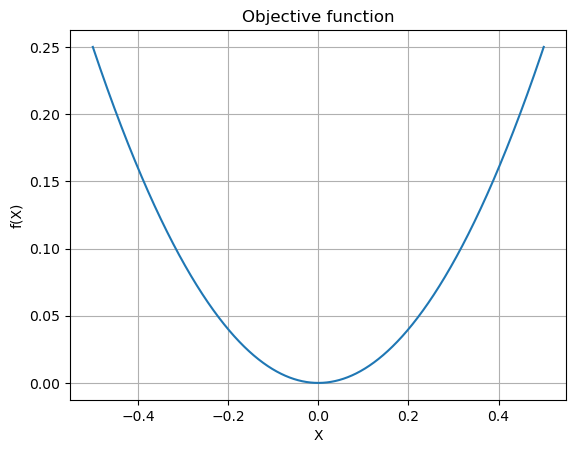

In [3]:
# define x
epsilon = 0.00001
x = np.arange(-0.5, 0.5, epsilon)
x_init = x
function = lambda x : x*x
fx = [function(e) for e in x]
plot_result(x_init, fx, "X", "f(X)", "Objective function")

x_train, x_test, y_train, y_test = create_dataset(x, fx)

[]

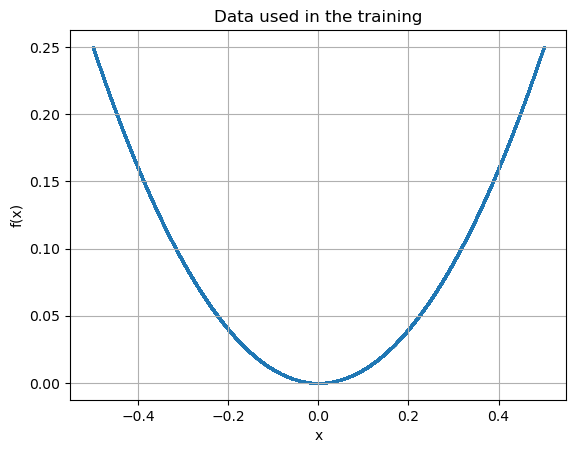

In [4]:
plt.scatter(x_train, y_train, 1)
plt.title("Data used in the training")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.plot()

## Simple regressor

We train in the example putting ourselves in the scenario we saw in class

In [5]:
regr = MLPRegressor(random_state=42, max_iter=2000, hidden_layer_sizes = (15, 15, 15)).fit(x_train, y_train)

In [6]:
epsilon = 10
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
preds = regr.predict(x_test)
preds_unif = regr.predict(x_unif)
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 10, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

The score on the training set is:  0.9997847773815813
The score on the constant resolution, epsilon = 10, is:  0.9996049227794005


In [7]:
# store the results
l1 = []
l2 = []
linf = []

The scores seem to be comparable in terms of R2 score. Let's analyse the scores induced by the L1, the L2 and the L-infinity norms. 

In [8]:
print("Test set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

Test set
L1 Error: 0.0834
L2 Error: 0.0111
L-inf Error: 0.2491

Uniform resolution set
L1 Error: 0.0986
L2 Error: 0.0159
L-inf Error: 0.2474


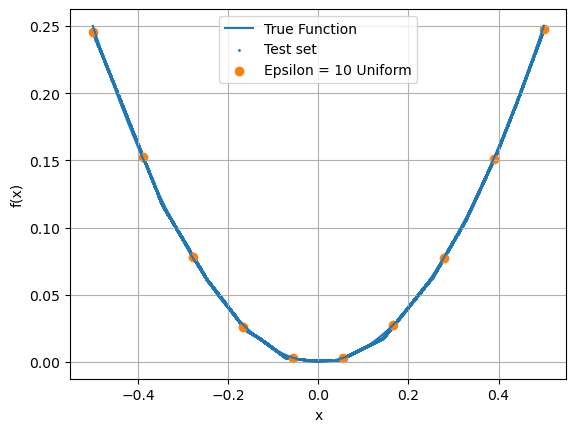

In [9]:
plt.scatter(x_test, preds, s=1, label="Test set")
plt.scatter(x_unif, preds_unif, label="Epsilon = 10 Uniform")
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

The results are good, we do not observe noticeable drifts from the main function. 

We now increase the epsilon value

In [10]:
epsilon = 30
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 30, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

print("\nTest set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

The score on the training set is:  0.9997847773815813
The score on the constant resolution, epsilon = 30, is:  0.9997369454846223

Test set
L1 Error: 0.0834
L2 Error: 0.0111
L-inf Error: 0.2491

Uniform resolution set
L1 Error: 0.0950
L2 Error: 0.0144
L-inf Error: 0.2477


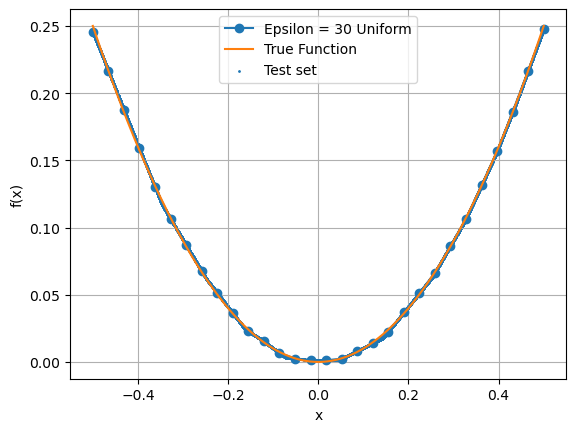

In [11]:
preds_unif = regr.predict(x_unif)

plt.scatter(x_test, preds, s=1, label="Test set")
plt.plot(x_unif, preds_unif, label="Epsilon = 30 Uniform", marker="o")
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

The results are still really good. We are incresing a lot the value of epsilo this time.

In [12]:
epsilon = 100
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 100, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

print("\nTest set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

The score on the training set is:  0.9997847773815813
The score on the constant resolution, epsilon = 100, is:  0.9997733189642022

Test set
L1 Error: 0.0834
L2 Error: 0.0111
L-inf Error: 0.2491

Uniform resolution set
L1 Error: 0.0869
L2 Error: 0.0121
L-inf Error: 0.2488


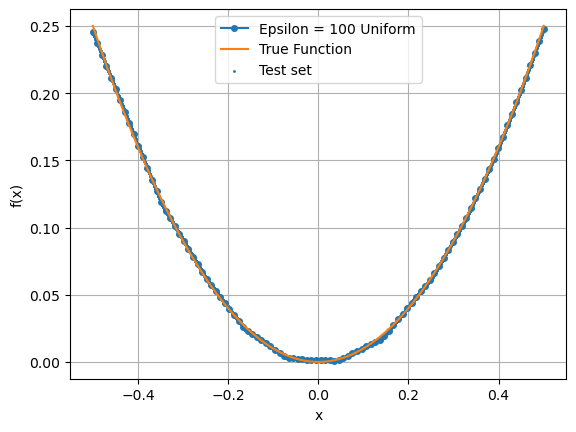

In [13]:
preds_unif = regr.predict(x_unif)

plt.scatter(x_test, preds, s=1, label="Test set")
plt.plot(x_unif, preds_unif, label="Epsilon = 100 Uniform", marker="o", markersize=4)
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

Let's have a closer look

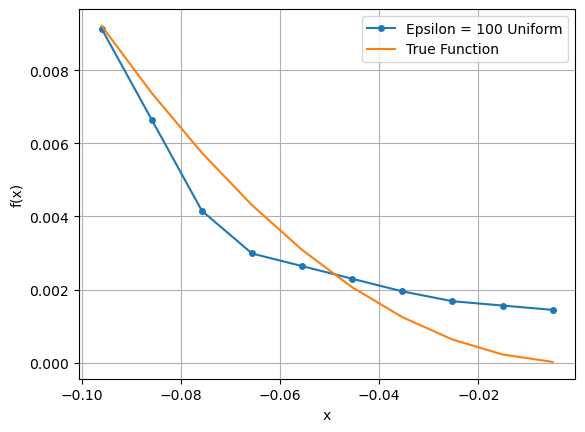

In [14]:
plt.plot(x_unif[40:50], preds_unif[40:50], label="Epsilon = 100 Uniform", marker="o", markersize=4)
plt.plot(x_unif[40:50], [function(x) for x in x_unif[40:50]], label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

In [15]:
confront_100_x = x_unif[40:50]
confront_100_y = preds_unif[40:50]

In [16]:
epsilon = 1000
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 1000, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

print("\nTest set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

The score on the training set is:  0.9997847773815813
The score on the constant resolution, epsilon = 1000, is:  0.9997864255510965

Test set
L1 Error: 0.0834
L2 Error: 0.0111
L-inf Error: 0.2491

Uniform resolution set
L1 Error: 0.0842
L2 Error: 0.0113
L-inf Error: 0.2490


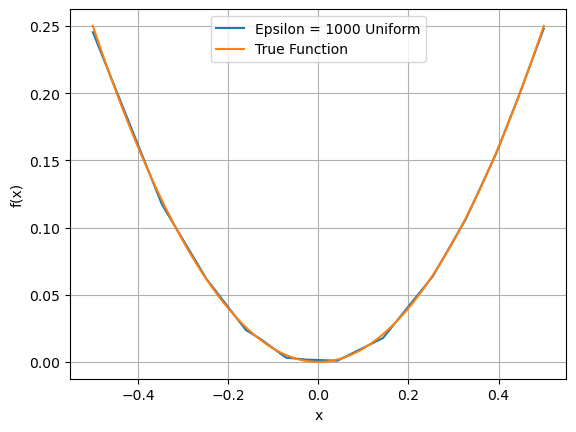

In [17]:
preds_unif = regr.predict(x_unif)

plt.plot(x_unif, preds_unif, label="Epsilon = 1000 Uniform")
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

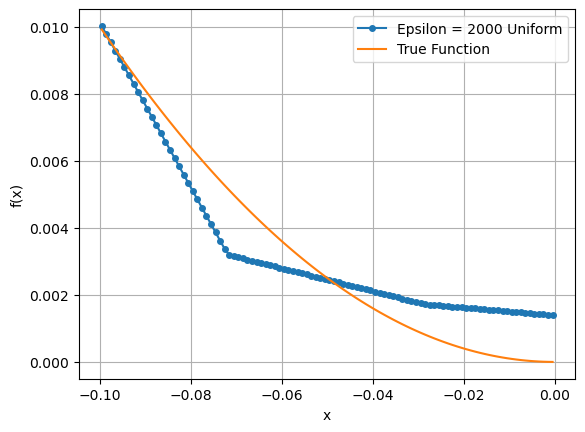

In [18]:
plt.plot(x_unif[400:500], preds_unif[400:500], label="Epsilon = 2000 Uniform", marker="o", markersize=4)
plt.plot(x_unif[400:500], [function(x) for x in x_unif[400:500]], label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

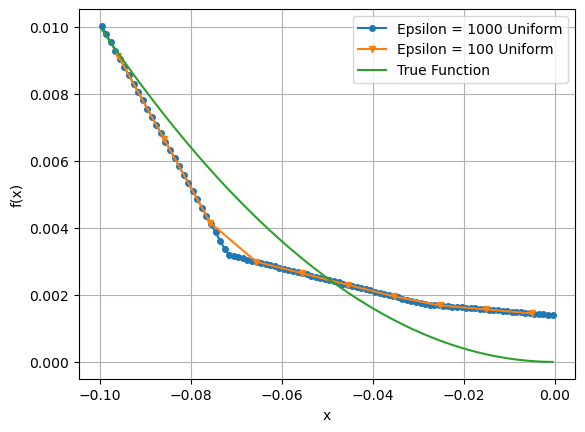

In [19]:
plt.plot(x_unif[400:500], preds_unif[400:500], label="Epsilon = 1000 Uniform", marker="o", markersize=4)
plt.plot(confront_100_x, confront_100_y, label="Epsilon = 100 Uniform", marker="v", markersize=4)
plt.plot(x_unif[400:500], [function(x) for x in x_unif[400:500]], label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

Having increased the resolution we are inspecting the function by a factor of ten it is remarkable to notice that it was not only a an unlucky point sampled by the uniform distribution, but there are sctructural limits on the learning we can perform.

Let's now consider the case where the resolution we are considering is really high

In [20]:
epsilon = 5000
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 5000, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

print("\nTest set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

The score on the training set is:  0.9997847773815813
The score on the constant resolution, epsilon = 5000, is:  0.9997875461144148

Test set
L1 Error: 0.0834
L2 Error: 0.0111
L-inf Error: 0.2491

Uniform resolution set
L1 Error: 0.0834
L2 Error: 0.0111
L-inf Error: 0.2491


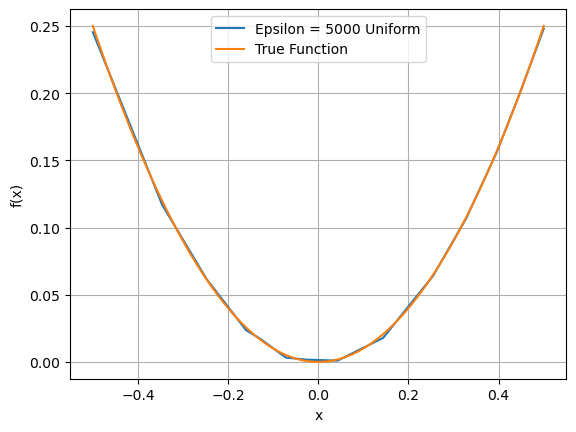

In [21]:
preds_unif = regr.predict(x_unif)

plt.plot(x_unif, preds_unif, label="Epsilon = 5000 Uniform")
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

Let's compare the error measures we acquired with respect to the different values of epsilon we chose

### L1 norm

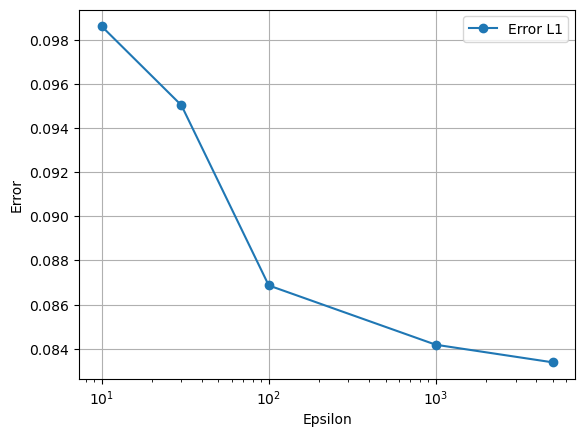

In [22]:
epsilons = [10, 30, 100, 1000, 5000]
plt.semilogx(epsilons, l1, label="Error L1", marker="o")
plt.grid()
plt.xlabel("Epsilon")
plt.ylabel("Error")
plt.legend()

### L2 norm

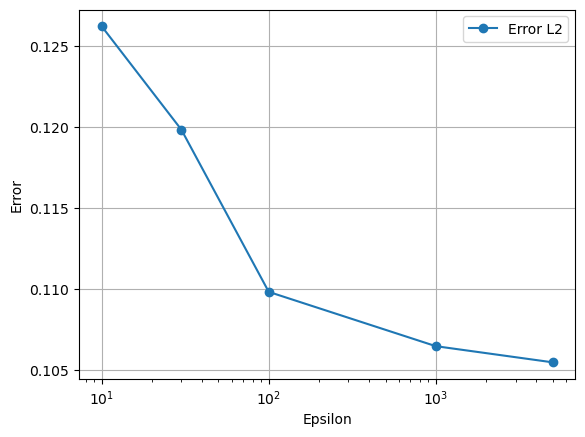

In [23]:
plt.semilogx(epsilons, l2, label="Error L2", marker="o")
plt.grid()
plt.xlabel("Epsilon")
plt.ylabel("Error")
plt.legend()

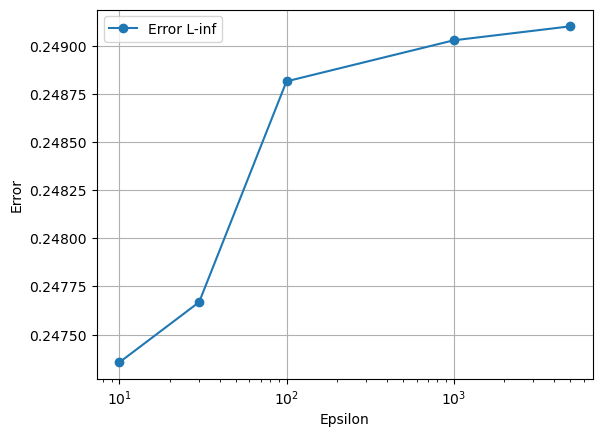

In [24]:
plt.semilogx(epsilons, linf, label="Error L-inf", marker="o")
plt.grid()
plt.xlabel("Epsilon")
plt.ylabel("Error")
plt.legend()

It's interesting to notice that there is an upward trend for the error associated with the infinity norm. This is relevant, because the error associated with the infinity norm is used to quantify the accuracy of a prediction or approximation, and is calculated as the difference between the actual values and the predicted values. 

This measure of error is particularly useful for problems where the impact of large errors is more important than the average error, as it gives an upper bound on the error.

Therefore we might conclude that, even though the average measures tend to go down in value, the maximum error increases with the resolution!

### Let's now compute the teoretical number of points needed

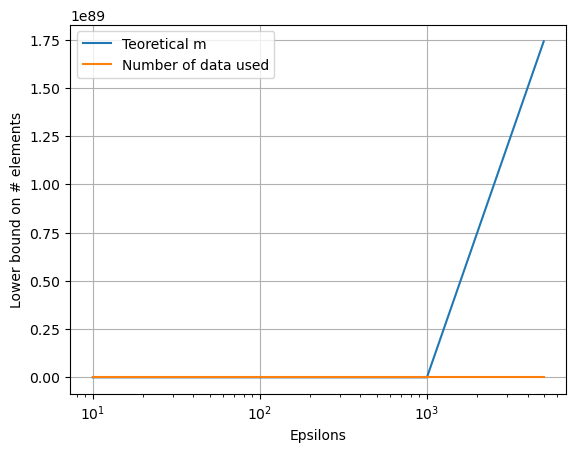

In [25]:
m_min = lambda x: 178**15 * x**(15)
ms = [m_min(e) for e in epsilons]
ourdata = [10000 for _ in epsilons]

plt.semilogx(epsilons, ms, label="Teoretical m")
plt.semilogx(epsilons, ourdata, label="Number of data used")
plt.xlabel("Epsilons")
plt.ylabel("Lower bound on # elements")
plt.grid()
plt.legend()


## Target function: x $\rightarrow$ log(sin(50x) + 2) + sin(5x)

Let's change the function with a worse one!

This function is simply much more difficult to predict than the 


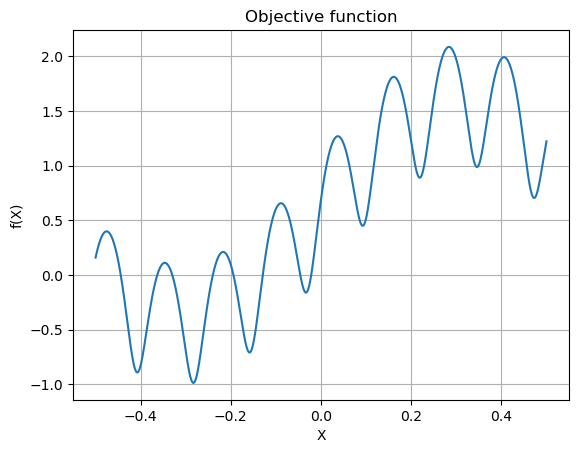

In [26]:
# define x
epsilon = 0.00001
x = np.arange(-0.5, 0.5, epsilon)
x_init = x
function = lambda x : np.log(np.sin(50 * x) + 2) + np.sin(5*x)
fx = [function(e) for e in x]
plot_result(x_init, fx, "X", "f(X)", "Objective function")

x_train, x_test, y_train, y_test = create_dataset(x, fx)

regr = MLPRegressor(random_state=42, max_iter=10000,
                    hidden_layer_sizes = (100, 100, 100, 100, 100)
                   ).fit(x_train, y_train)

#### Epsilon = 10

In [27]:
epsilon = 10
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
preds = regr.predict(x_test)
preds_unif = regr.predict(x_unif)
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 10, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

The score on the training set is:  0.9978556077698066
The score on the constant resolution, epsilon = 10, is:  0.9902680121676224


In [28]:
# store the results
l1 = []
l2 = []
linf = []

print("Test set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

Test set
L1 Error: 0.9947
L2 Error: 1.4882
L-inf Error: 3.0981

Uniform resolution set
L1 Error: 1.2105
L2 Error: 2.2630
L-inf Error: 3.0483


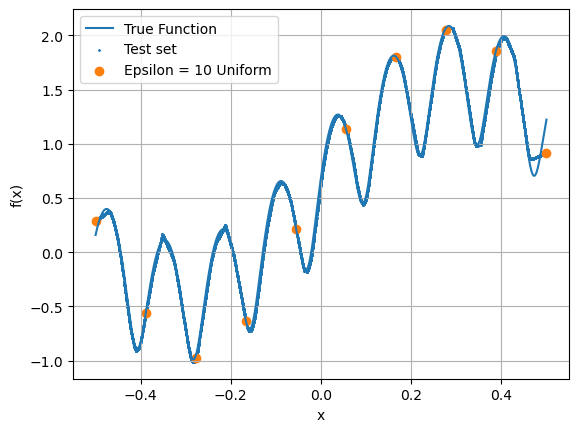

In [29]:
plt.scatter(x_test, preds, s=1, label="Test set")
plt.scatter(x_unif, preds_unif, label="Epsilon = 10 Uniform")
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

#### Epsilon=30

In [30]:
epsilon = 30
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 30, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

print("\nTest set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

The score on the training set is:  0.9978556077698066
The score on the constant resolution, epsilon = 30, is:  0.9934410981549495

Test set
L1 Error: 0.9947
L2 Error: 1.4882
L-inf Error: 3.0981

Uniform resolution set
L1 Error: 1.1072
L2 Error: 1.8179
L-inf Error: 3.0248


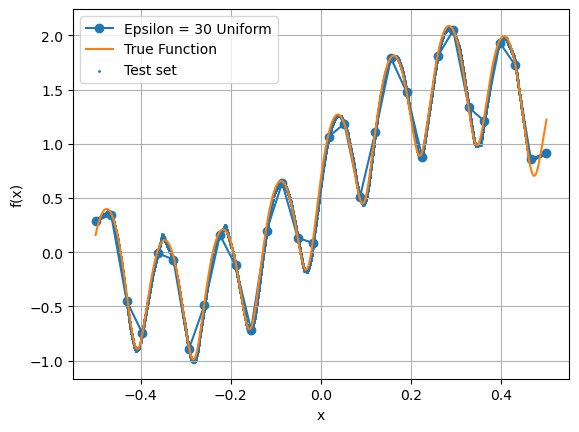

In [31]:
preds_unif = regr.predict(x_unif)

plt.scatter(x_test, preds, s=1, label="Test set")
plt.plot(x_unif, preds_unif, label="Epsilon = 30 Uniform", marker="o")
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

#### Epsilon = 100

In [32]:
epsilon = 100
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 100, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

print("\nTest set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

The score on the training set is:  0.9978556077698066
The score on the constant resolution, epsilon = 100, is:  0.996871754158835

Test set
L1 Error: 0.9947
L2 Error: 1.4882
L-inf Error: 3.0981

Uniform resolution set
L1 Error: 0.9701
L2 Error: 1.4189
L-inf Error: 3.0052


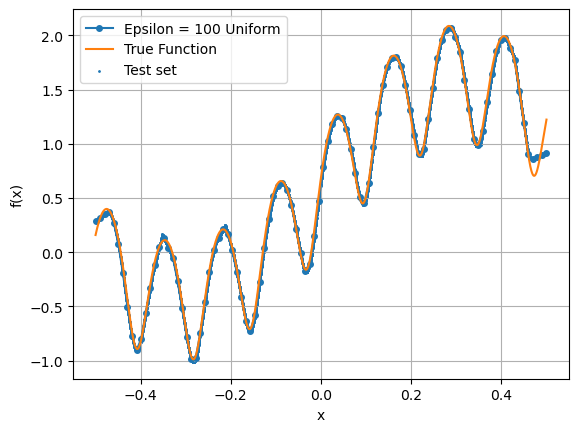

In [33]:
preds_unif = regr.predict(x_unif)

plt.scatter(x_test, preds, s=1, label="Test set")
plt.plot(x_unif, preds_unif, label="Epsilon = 100 Uniform", marker="o", markersize=4)
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

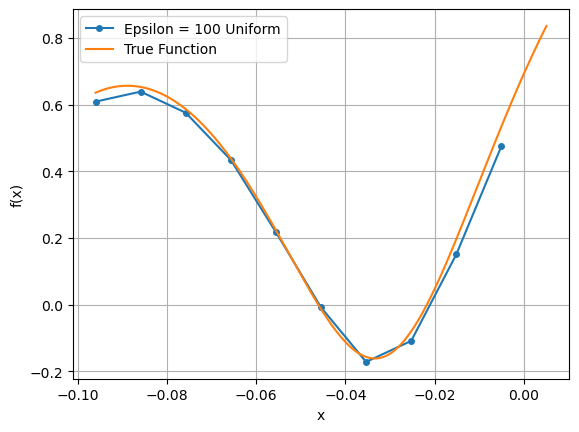

In [34]:
plt.plot(x_unif[40:50], preds_unif[40:50], label="Epsilon = 100 Uniform", marker="o", markersize=4)
xmin = x_unif[40]
xmax = x_unif[50]
x_unif_zoom = np.linspace(xmin, xmax, 200)
plt.plot(x_unif_zoom, [function(x) for x in x_unif_zoom], label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

In [35]:
confront_100_x = x_unif[40:50]
confront_100_y = preds_unif[40:50]

#### Epsilon = 1000

In [36]:
epsilon = 1000
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 1000, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

print("\nTest set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

The score on the training set is:  0.9978556077698066
The score on the constant resolution, epsilon = 1000, is:  0.9977156242447824

Test set
L1 Error: 0.9947
L2 Error: 1.4882
L-inf Error: 3.0981

Uniform resolution set
L1 Error: 0.9775
L2 Error: 1.4383
L-inf Error: 3.0732


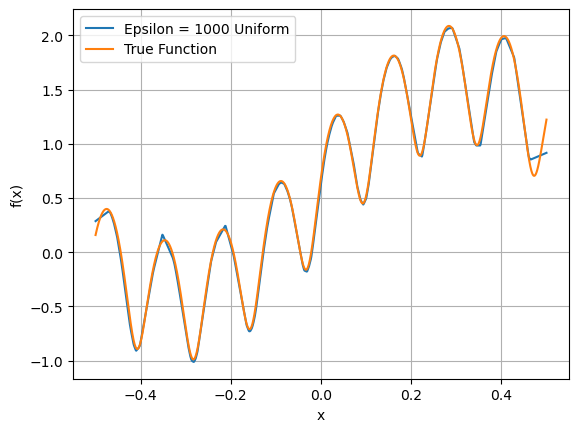

In [37]:
preds_unif = regr.predict(x_unif)

plt.plot(x_unif, preds_unif, label="Epsilon = 1000 Uniform")
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

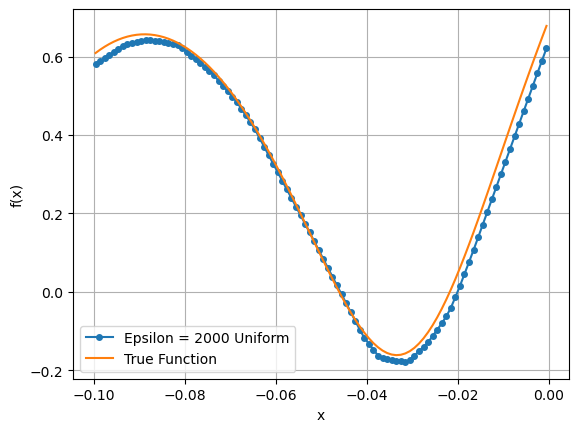

In [38]:
plt.plot(x_unif[400:500], preds_unif[400:500], label="Epsilon = 2000 Uniform", marker="o", markersize=4)
plt.plot(x_unif[400:500], [function(x) for x in x_unif[400:500]], label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

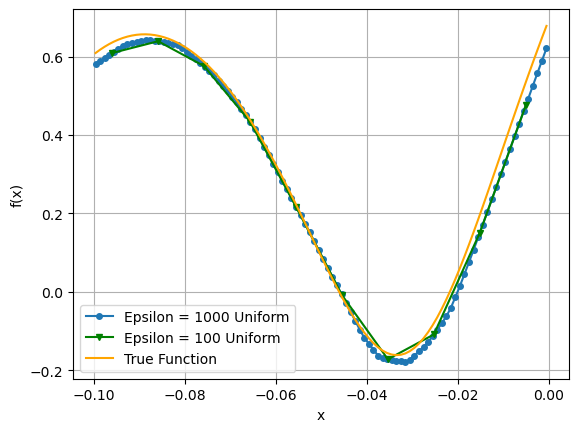

In [39]:
plt.plot(x_unif[400:500], preds_unif[400:500], label="Epsilon = 1000 Uniform", marker="o", markersize=4)
plt.plot(confront_100_x, confront_100_y, label="Epsilon = 100 Uniform", marker="v", markersize=4, color="green")
plt.plot(x_unif[400:500], [function(x) for x in x_unif[400:500]], label="True Function", color="orange")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

#### Epsilon = 5000

In [40]:
epsilon = 5000
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 5000, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

print("\nTest set")
MAD, MSE, INFN = compute_errors(preds, y_test.cpu().detach().numpy())

print("\nUniform resolution set")
l1_u, l2_u, linf_u = compute_errors(preds_unif, [function(e) for e in x_unif])
l1.append(l1_u)
l2.append(l2_u)
linf.append(linf_u)

The score on the training set is:  0.9978556077698066
The score on the constant resolution, epsilon = 5000, is:  0.9977777817358933

Test set
L1 Error: 0.9947
L2 Error: 1.4882
L-inf Error: 3.0981

Uniform resolution set
L1 Error: 0.9795
L2 Error: 1.4438
L-inf Error: 3.0978


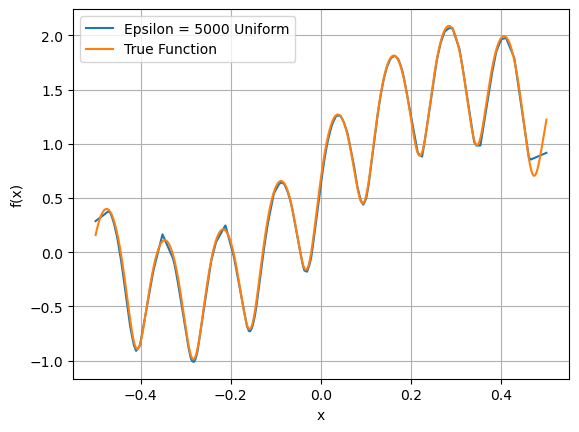

In [41]:
preds_unif = regr.predict(x_unif)

plt.plot(x_unif, preds_unif, label="Epsilon = 5000 Uniform")
plt.plot(x_init, fx, label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()

### L1 norm

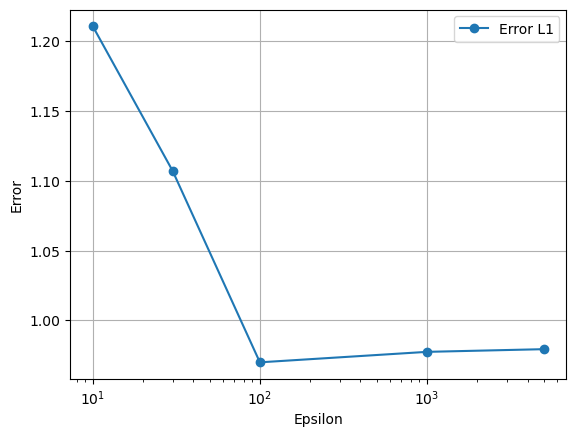

In [42]:
epsilons = [10, 30, 100, 1000, 5000]
plt.semilogx(epsilons, l1, label="Error L1", marker="o")
plt.grid()
plt.xlabel("Epsilon")
plt.ylabel("Error")
plt.legend()

### L2 norm

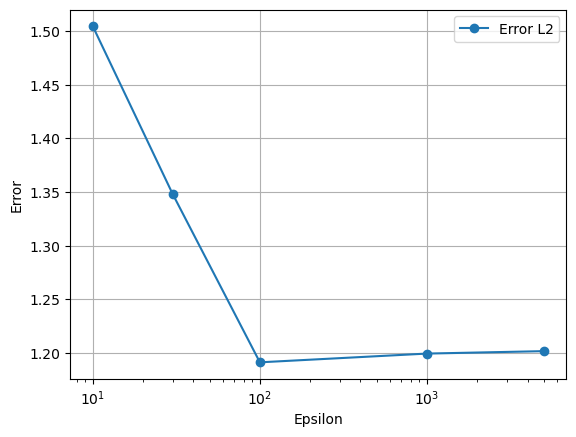

In [43]:
plt.semilogx(epsilons, l2, label="Error L2", marker="o")
plt.grid()
plt.xlabel("Epsilon")
plt.ylabel("Error")
plt.legend()

### L inf norm

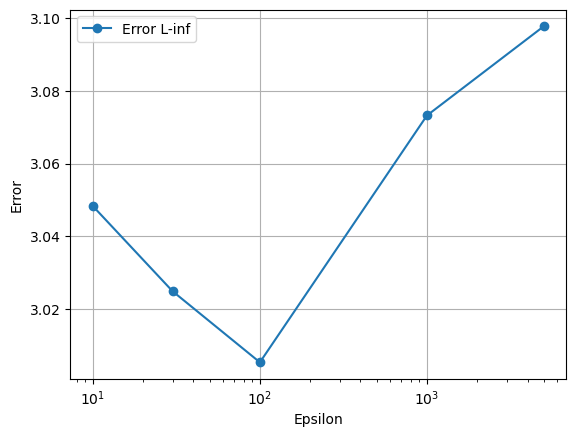

In [44]:
plt.semilogx(epsilons, linf, label="Error L-inf", marker="o")
plt.grid()
plt.xlabel("Epsilon")
plt.ylabel("Error")
plt.legend()

### What would be the number of data we would need?

In [45]:
m_min = lambda x: ((0.47 * (10**10))**100 * x**(-100))
ms = [m_min(e) for e in epsilons]
ourdata = [10000 for _ in epsilons]

plt.semilogx(epsilons, ms, label="Teoretical m")
plt.semilogx(epsilons, ourdata, label="Number of data used")
plt.xlabel("Epsilons")
plt.ylabel("Lower bound on # elements")
plt.grid()
plt.legend()


OverflowError: (34, 'Result too large')

The number of data needed to have the function reconstructed with the given resolution is simply ridicolously high.